# ML Capstone: Iceberg Classifier


## Domain Background

Icebergs presents threats to the ships navigation and various offshore activities. Especially, it as actual problem for the area offshore to Newfoundland and Labrador known as Iceberg Alley. The primary iceberg detection method for now is aerial reconnaissance using vessel-based monitoring data. Also, data received though satellites are widely being integrated now onto the monitoring systems greatly reduce monitoring cost. Additionally, Synthetic Aperture Radar (SAR) satellites can still monitor in various weather conditions such as clouds and fog.
However, manual visual classification of SAR images to identify iceberg is very time-consuming process. So, C‑CORE company (https://www.c-core.ca/) has developed a computer vision system that analyzes SAR data to automatically detect and classify icebergs and vessels. Now it challenges ML community to build effective classification algorithm for their detection system [1]

## Problem Statement

The goal of the project is to build an algorithm which can reliably classify data to identify either it is iceberg or ship, based on given Synthetic Aperture Radar data. Also, the results are clearly measurable using prediction accuracy and it is important to have classifier with higher accuracy (ideally 100%).
Additionally, analysis and classification SAR data is interesting problem. Even if it seems like standard image classification task it has some important differences which makes it challengeable to use pre-trained neural networks with transfer learning for the image classification such as VGG [2] or Inception [3]:
• SAR data is not a three-channels regular image
• Radar detected shapes are different than visually detected shapes.
• Data set has additional incidence angle parameter of which the image was taken. So, it is additional

#### Import nessesary libraries

In [1]:
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

## Datasets and Inputs

CORE provided dataset of satellite SAR images containing either a ship or an iceberg including 1604 training samples and 8424 test samples (5000 from them are autogenerated) Data was collected from SAR which bounces a signal off an object and records the echo, then that data is translated into an image. Two channels of image are provided: HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). See [4] for more details. Data was packed to the two JSON files (train.json, test.json). Each file consists of list of satellite images in following format:

Data was packed to the two JSON files (train.json, test.json). Each file consists of list of satellite images in following format: 
* Id of the image 
* band1 – flatten image data of the HH channel (5625 elements, 75x75 image), each element is float value measured in dB. 
* band2 – flatten image data of the HV channel (5625 elements, 75x75 image) , each element is float value measured in dB. 
* inc_angle - the incidence angle of which the image was taken 
* is_iceberg – classification label of the image. 1 is for iceberg, 0 for ship.

Training dataset the only dataset which has labels assigned – so it will be used for training and validation. Test dataset does not have labels and will be used for the model evaluation.
For the model features we are going to use band1, band2 and inc_angle data as features and is_iceberg field as labels.


#### Utility function to load data from JSON file

In [2]:
def read_data(filename):
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    return data

#### Utility functions to find global dataset characteristics (signal strength min/max, angle min/max)

In [3]:
def find_signal_minmax(data):
    mins = [min(min(item['band_1']), min(item['band_2'])) for item in data ]
    maxes = [max(max(item['band_1']), max(item['band_2'])) for item in data ]

    global_min = min(mins)
    global_max = max(maxes)
    
    return global_min, global_max

def find_angle_minmax(data):
    global_min  = min( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'  ])
    global_max = max( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'])
  
    return global_min, global_max

#### Utility functions to extract and display 75*75 image from raw SAR JSON data

In [4]:
def extract_image(data_item, key, image_size = 75):
    image = np.array(data_item[key])
    image = image.reshape(image_size, image_size)
    return image
    
def extract_images(data_item, image_size = 75):
    hh_image = extract_image(data_item, 'band_1', image_size)
    hv_image = extract_image(data_item, 'band_2', image_size)
    return hh_image, hv_image
     
def display_image(image, cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.show()

#### Image pre-processing and normalization functions

In [5]:
def global_min_max_scale_sar_image(image, global_min, global_max):
    image = (image - global_min) / (global_max - global_min)
    return image

def local_min_max_scale_sar_image(image):
    img_min = np.min(image)
    img_max = np.max(image)
    
    image = (image - img_min) / (img_max - img_min)
    return image

def local_standard_scale_sar_image(image):
    img_mean = np.mean(image)
    img_std = np.std(image)
    
    image = (image - np.ones_like(image) * img_mean) / img_std;
    
    return image

def flatten_image(image):
    image = image.flatten()
    return image

#### Create 2-channel Images for CNN from HH and HV SAR channels ignoring angle data

In [6]:
def prepare_dataset_ignore_angles(data, process_func):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        hh_image, hv_image = extract_images(item)
        hh_image = process_func(hh_image)
        hv_image = process_func(hv_image)
        
        image = np.dstack((hh_image, hv_image))
        X.append(image)
        if 'is_iceberg' in item.keys():
            labels.append(item['is_iceberg'])
        else:
            labels.append(0)
            
        ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

#### Create 3-channel Images for CNN from HH and HV SAR channels + angle data as separate layer

In [7]:
def prepare_dataset_with_angles(data, process_func, angle_processing):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        angle = item['inc_angle']
        if angle != 'na':
            hh_image, hv_image = extract_images(item)
            hh_image = process_func(hh_image)
            hv_image = process_func(hv_image)
            angle_layer = np.ones_like(hh_image) * angle_processing(angle)
            image = np.dstack((hh_image, hv_image, angle_layer))
            X.append(image)
            if 'is_iceberg' in item.keys():
                labels.append(item['is_iceberg'])
            else:
                labels.append(0)

            ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

#### Create flat features for simple classifiers algoirithms like Logistic Regression, Support vector machines

In [8]:
def prepare_flat_dataset_with_angles(data, process_func, angle_processing):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        angle = item['inc_angle']
        if angle != 'na':
            hh_image, hv_image = extract_images(item)
            hh_image = process_func(hh_image).flatten()
            hv_image = process_func(hv_image).flatten()
            angle_layer = angle_processing(angle)
            x_item = np.concatenate((hh_image, hv_image, [angle_layer]))
            X.append(x_item)
            if 'is_iceberg' in item.keys():
                labels.append(item['is_iceberg'])
            else:
                labels.append(0)

            ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

In [9]:
def cut_image_part(data, margin):
    return data[:, margin : -margin, margin : - margin, :]

#### Load training data

In [10]:
train_file = 'data/train.json'
train_data = read_data(train_file)
print('Training dataset size: {}'.format(len(train_data)))

Training dataset size: 1604


#### Find global parameters

In [11]:
image_size = 75

angle_min, angle_max = find_angle_minmax(train_data)
global_min, global_max = find_signal_minmax(train_data)

print("Minimum incidence angle = {}, Maximum incidence angle = {}".format(angle_min, angle_max))
print("Minimum signal strength (dB)= {}, Maximum signal strength (dB) = {}".format(global_min, global_max))

Minimum incidence angle = 24.7546, Maximum incidence angle = 45.9375
Minimum signal strength (dB)= -45.655499, Maximum signal strength (dB) = 34.574917


#### Prepare and run image workflow to  extract training data

In [12]:
import cv2

def process(image):
    image = local_min_max_scale_sar_image(image)
    #image = cv2.bilateralFilter(image.astype(np.float32), 5, 80, 80)
    return image
    
ptocessing_lambda = lambda image: process(image)
ptocessing_angle_lambda = lambda angle: 1.0 - (angle_max - angle) / (angle_max - angle_min)

#X_train_initial, y_train_initial, _ = prepare_dataset_ignore_angles(train_data, ptocessing_lambda)
X_train_initial, y_train_initial, _ = prepare_dataset_with_angles(train_data, ptocessing_lambda, ptocessing_angle_lambda)

#X_train, y_train, _ = prepare_dataset_with_angle(train_data, global_min, global_max, angle_min, angle_max)
print('Training dataset size: {}'.format(len(X_train_initial)))

Training dataset size: 1471


In [13]:
def get_image_channels(data, index):
    hh_channel = data[index, :, :, 0]
    hv_channel = data[index, :, :, 1]
    return hh_channel, hv_channel

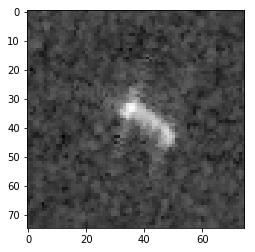

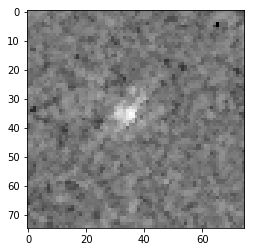

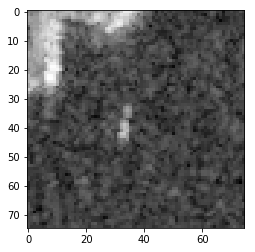

In [14]:
hh_channel, hv_channel = get_image_channels(X_train_initial, 24)
display_image(hh_channel)

hh_channel, hv_channel = get_image_channels(X_train_initial, 25)
display_image(hh_channel)

hh_channel, hv_channel = get_image_channels(X_train_initial, 26)
display_image(hh_channel)

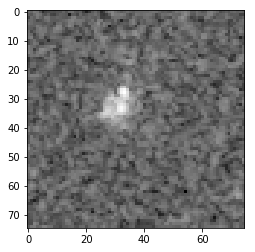

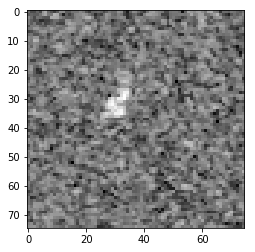

1


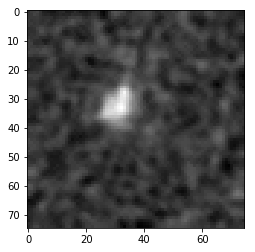

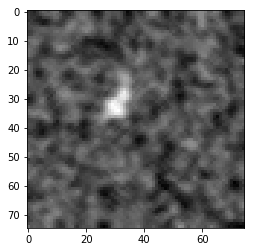

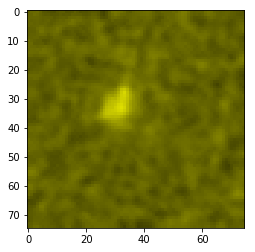

In [15]:
index = 1250

hh_image, hv_image =  get_image_channels(X_train_initial, index)
display_image(hh_image)
display_image(hv_image)

print(y_train_initial[index])

import cv2

hh_image = cv2.bilateralFilter(hh_image.astype(np.float32), 5, 80, 80)
hv_image = cv2.bilateralFilter(hv_image.astype(np.float32), 5, 80, 80)

display_image(hh_image)
display_image(hv_image)


image = np.dstack((hh_image, hh_image, np.zeros_like(hv_image)))
plt.imshow(image)
plt.show()

## Simple classifiers

In [16]:
import cv2

def process(image):
    image = local_min_max_scale_sar_image(image)
    return image
    
ptocessing_lambda = lambda image: process(image)
ptocessing_angle_lambda = lambda angle: 1.0 - (angle_max - angle) / (angle_max - angle_min)

X_flat_initial, y_flat_initial, _ = prepare_flat_dataset_with_angles(train_data, ptocessing_lambda, ptocessing_angle_lambda)

print('Training dataset size: {}'.format(len(X_flat_initial)))

Training dataset size: 1471


#### Split initial dataset to training and validation set

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_flat_initial, y_flat_initial, test_size=0.2, random_state=42)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final validation dataset size: {}'.format(len(X_valid)))

Final training dataset size: 1176
Final validation dataset size: 295


In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree  import DecisionTreeClassifier

from time import time
import json

clf1= LogisticRegression(random_state = 3)
clf2 = AdaBoostClassifier(random_state = 3)
clf3 = SVC(random_state = 3)
clf4 = DecisionTreeClassifier(random_state = 3)

from sklearn.metrics import log_loss, accuracy_score 

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}
    
    start = time() # Get start time
  
    learner.fit(X_train, y_train)
    
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    X_train_pred = X_train[:300]
    y_train_pred = y_train[:300]
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train_pred)
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train_pred, predictions_train)
    results['log_loss_train'] = log_loss(y_train_pred, predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['log_loss_test'] = log_loss(y_test, predictions_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, len(X_train)))
        
    # Return the results
    return results

print(train_predict(clf1, X_train, y_train, X_valid, y_valid))
print(train_predict(clf2, X_train, y_train, X_valid, y_valid))
print(train_predict(clf3, X_train, y_train, X_valid, y_valid))


LogisticRegression trained on 1176 samples.
{'train_time': 2.3636345863342285, 'log_loss_train': 9.9920072216264148e-16, 'pred_time': 0.011500120162963867, 'acc_train': 1.0, 'log_loss_test': 6.9078393044748019, 'acc_test': 0.80000000000000004}
AdaBoostClassifier trained on 1176 samples.
{'train_time': 56.3687481880188, 'log_loss_train': 1.3815643824202646, 'pred_time': 0.19403505325317383, 'acc_train': 0.95999999999999996, 'log_loss_test': 8.3128281638591055, 'acc_test': 0.7593220338983051}
SVC trained on 1176 samples.
{'train_time': 12.975327014923096, 'log_loss_train': 8.9802097982656104, 'pred_time': 6.013159990310669, 'acc_train': 0.73999999999999999, 'log_loss_test': 8.898258258600988, 'acc_test': 0.74237288135593216}


In [19]:
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import fbeta_score, make_scorer

dtc = DecisionTreeClassifier(random_state = 3)

clf_default = AdaBoostClassifier(random_state = 3, base_estimator = dtc) 
clf = AdaBoostClassifier(random_state = 3, base_estimator = dtc)

# TODO: Create the parameters list you wish to tune
parameters = { 'n_estimators': [5, 10, 20, 50, 100], \
              # 'base_estimator__criterion' : ['gini', 'entropy'], \
               'base_estimator__max_depth': [2, 3, 5, 10, None] \
             #  'base_estimator__min_samples_split': [2, 5, 10, 50], \
             #  'base_estimator__class_weight': [{ 1 : 0.75}, { 1 : 1}] 
             } 

scorer = make_scorer(log_loss, greater_is_better=False)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


KeyboardInterrupt: 

In [19]:
def_model = clf_default.fit(X_train, y_train)

NameError: name 'clf_default' is not defined

In [40]:
# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = def_model.predict(X_valid)
best_predictions = best_clf.predict(X_valid)

print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_valid, predictions)))
print ("log_loss on testing data: {:.4f}".format(log_loss(y_valid, predictions)))

print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_valid, best_predictions)))
print ("Final log_loss on the testing data: {:.4f}".format(log_loss(y_valid, best_predictions)))
                                                                     
print (grid_fit.best_params_)

NameError: name 'grid_fit' is not defined

#### Split initial dataset to training and validation set

In [41]:
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train_initial, y_train_initial, test_size=0.05, random_state=142)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.33, random_state=42)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final validation dataset size: {}'.format(len(X_valid)))
print('Final tet dataset size: {}'.format(len(X_test_1)))

Final training dataset size: 935
Final validation dataset size: 462
Final tet dataset size: 74


In [42]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=180, width_shift_range = 0.05, height_shift_range = 0.05, 
                             horizontal_flip = True, vertical_flip = True)
datagen.fit(X_train)

#X_train_new = np.copy(X_train)
#Y_train_new = np.copy(y_train)

#for i in range(40):
#    X_batch, y_batch =  next(datagen.flow(X_train, y_train, batch_size=2000))
#    if i == 0:
#        X_train_new = X_batch
#        Y_train_new = y_batch
#    else: 
#        X_train_new = np.concatenate((X_train_new, X_batch), axis=0)
#        Y_train_new = np.concatenate((Y_train_new, y_batch), axis=0)
    
    #plt.imshow(X_batch[24, :, :, 0])
    #plt.show()
                                    
    
#print(X_batch.shape)


#print (X_batch.shape)
##X_train = cut_image_part(X_train_new, 10)
#print (X_train_new.shape)







## Inception

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model

base_model = InceptionV3(include_top=False, weights='imagenet')
model = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_initial, y_train_initial, test_size=0.2, random_state=42)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final validation dataset size: {}'.format(len(X_valid)))

features_train = []
features_valid = []

for x in X_train:
    x = np.expand_dims(x, axis = 0)
    feature = model.predict(x)
    flat = feature.flatten()
    features_train.append(flat)

for x in X_valid:
    x = np.expand_dims(x, axis = 0)
    feature = model.predict(x)
    flat = feature.flatten()
    features_valid.append(flat)


In [ ]:
lrc = LogisticRegression(random_state = 3)
lrc = SVC(random_state = 3)

results = {}
    
start = time() # Get start time
lrc.fit(features_train, y_train)
end = time() # Get end time
results['train_time'] = end - start


start = time() # Get start time
predictions_test = lrc.predict(features_valid)
predictions_train = lrc.predict(features_train)
end = time() # Get end time
    
results['pred_time'] = end - start
results['acc_train'] = accuracy_score(y_train, predictions_train)
results['log_loss_train'] = log_loss(y_train, predictions_train)
results['acc_test'] = accuracy_score(y_valid, predictions_test)
results['log_loss_test'] = log_loss(y_valid, predictions_test)
       
print ("{} trained on {} samples.".format(lrc.__class__.__name__, len(features_train)))

results

## Model

In [16]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense
from keras.initializers import RandomNormal
from keras.regularizers import l2

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model


entities_count = 20

def getModel10(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    return model

def getModel11(num_layers):
    activation = 'relu'
    model = Sequential()
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None) ))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None) ))
    model.add(Activation(activation))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)  ))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None) ))
    model.add(Activation(activation))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None) ))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None) ))
    model.add(Activation(activation))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.35))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.35))
    model.add(Dense(1, activation="sigmoid"))

    return model
    
def getModelBest(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model


def getModel20(num_layers):
    activation = 'elu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(2, 2), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model


def getTransferLearningModel():
    activation = 'elu'
    base_model = InceptionV3(include_top=False, weights='imagenet')
    output = base_model.output
    
    layer = GlobalMaxPooling2D()(output)
    layer = Dense(512, activation='relu', name='fc2')(layer)
    layer = Dropout(0.3)(layer)
    layer = Dense(512, activation='relu', name='fc3')(layer)
    layer = Dropout(0.3)(layer)
    predictions = Dense(1, activation='sigmoid')(layer)
   
    model = Model(input=base_model.input, output=predictions)
  
    return model

Using TensorFlow backend.


In [17]:
def getModel30(num_layers):
    activation = 'elu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

def getModel32(num_layers):
    activation = 'elu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
 

    
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
    
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
    
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
    
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Activation(activation))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1, activation="sigmoid"))
    
    
    return model

def getModel31(num_layers):
    activation = 'relu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

def getModel40(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False,
                     kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model



def getModel50(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model

In [18]:
model = getModel11(3)
#model = getTransferLearningModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 64)        1728      
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        36864     
_________________________________________________________________
activation_2 (Activation)    (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 128)       73856     
_________________________________________________________________
activation_3 (Activation)    (None, 38, 38, 128)       0         
__________

In [28]:
batch_size = 192
epochs = 150

def init_model(model, file_name):
    checkpointer = ModelCheckpoint(filepath=file_name, verbose=1, save_best_only=True)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
    #optimizer_small = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
    #optimizer2 = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


    return model, checkpointer

In [33]:
from keras.callbacks import ModelCheckpoint  
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.model_selection import train_test_split
from keras.models import load_model

#X_train_initial2 = X_train_initial[:,:,:, 1:3]
X_train, X_test, y_train, y_test = train_test_split(X_train_initial, y_train_initial, test_size=0.1, random_state=598)

print('Final training dataset size: {}'.format(len(X_train)))
print('Final test dataset size: {}'.format(len(X_test)))

K = 6
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=98).split(X_train, y_train))

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=0, width_shift_range = 0, height_shift_range = 0, 
                             horizontal_flip = True, vertical_flip = True)

#res = model.fit(train_tensors, train_targets, 
#          validation_data = (X_valid, y_valid),
#          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)
mean_loss = 0

for i, (train_idx, valid_idx) in enumerate(folds):
    print("Fold: {}".format(i))
    file_name = 'saved_models/fold{}.weights.best.from_scratch.hdf5'.format(i)

    model, checkpointer = init_model(getModel11(3), file_name)
    
    X_train_ = X_train[train_idx]
    y_train_ = y_train[train_idx]
    X_valid_ = X_train[valid_idx]
    y_valid_ =  y_train[valid_idx]

    datagen.fit(X_train_)

    res = model.fit_generator(datagen.flow(X_train_, y_train_, batch_size=batch_size),  steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = (X_valid_, y_valid_), verbose=1, callbacks=[checkpointer])
    
    
    prediction_model = load_model(file_name )
    
    test_score = prediction_model.evaluate(X_test, y_test)
 
    print('Test loss:', test_score[0])
    print('Test accuracy:', test_score[1])
    
    mean_loss += test_score[0] / K
        
#res = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
#                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = (X_valid, y_valid), verbose=1, callbacks=[checkpointer])

print('Mean loss:',   mean_loss)

Final training dataset size: 1323
Final test dataset size: 148
Fold: 0
Epoch 1/160
11/10 [===============================] - 7s - loss: 0.6980 - acc: 0.5108 - val_loss: 0.6930 - val_acc: 0.5180
Epoch 2/160
11/10 [===============================] - 4s - loss: 0.6929 - acc: 0.5282 - val_loss: 0.6924 - val_acc: 0.5180
Epoch 3/160
11/10 [===============================] - 1s - loss: 0.6906 - acc: 0.5135 - val_loss: 0.6929 - val_acc: 0.5180
Epoch 4/160
11/10 [===============================] - 4s - loss: 0.6769 - acc: 0.5284 - val_loss: 0.6681 - val_acc: 0.5811
Epoch 5/160
11/10 [===============================] - 1s - loss: 0.7018 - acc: 0.5921 - val_loss: 0.6836 - val_acc: 0.6667
Epoch 6/160
11/10 [===============================] - 1s - loss: 0.6882 - acc: 0.5825 - val_loss: 0.6832 - val_acc: 0.5180
Epoch 7/160
11/10 [===============================] - 4s - loss: 0.6740 - acc: 0.6060 - val_loss: 0.6522 - val_acc: 0.7027
Epoch 8/160
 2/10 [====>.........................] - ETA: 3s - loss:

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.406005). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203502). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 4s - loss: 0.6333 - acc: 0.6921 - val_loss: 0.6105 - val_acc: 0.7117
Epoch 9/160
11/10 [===============================] - 4s - loss: 0.5868 - acc: 0.6868 - val_loss: 0.6059 - val_acc: 0.6351
Epoch 10/160
11/10 [===============================] - 1s - loss: 0.5891 - acc: 0.7068 - val_loss: 0.7635 - val_acc: 0.5225
Epoch 11/160
11/10 [===============================] - 1s - loss: 0.6644 - acc: 0.5906 - val_loss: 0.6149 - val_acc: 0.6892
Epoch 12/160
11/10 [===============================] - 4s - loss: 0.5935 - acc: 0.7050 - val_loss: 0.5664 - val_acc: 0.7027
Epoch 13/160
11/10 [===============================] - 4s - loss: 0.5565 - acc: 0.7336 - val_loss: 0.5574 - val_acc: 0.7117
Epoch 14/160
11/10 [===============================] - 1s - loss: 0.5484 - acc: 0.7364 - val_loss: 0.6077 - val_acc: 0.6622
Epoch 15/160
11/10 [===============================] - 4s - loss: 0.5571 - acc: 0.7238 - val_loss: 0.5453 - val_acc: 0.7117
Epoch 16/160
11/10 [==

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.664002). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.332501). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.4805 - acc: 0.7595 - val_loss: 0.5373 - val_acc: 0.7342
Epoch 24/160
11/10 [===============================] - 4s - loss: 0.4862 - acc: 0.7547 - val_loss: 0.4682 - val_acc: 0.7297
Epoch 25/160
11/10 [===============================] - 4s - loss: 0.4356 - acc: 0.7827 - val_loss: 0.4543 - val_acc: 0.7387
Epoch 26/160
11/10 [===============================] - 1s - loss: 0.5488 - acc: 0.7064 - val_loss: 0.5411 - val_acc: 0.7252
Epoch 27/160
11/10 [===============================] - 4s - loss: 0.4803 - acc: 0.7624 - val_loss: 0.4533 - val_acc: 0.7658
Epoch 28/160
11/10 [===============================] - 4s - loss: 0.4853 - acc: 0.7413 - val_loss: 0.4434 - val_acc: 0.7703
Epoch 29/160
11/10 [===============================] - 4s - loss: 0.4656 - acc: 0.7483 - val_loss: 0.4349 - val_acc: 0.7658
Epoch 30/160
 2/10 [====>.........................] - ETA: 4s - loss: 0.4331 - acc: 0.8203

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.650001). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.325001). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 5s - loss: 0.4395 - acc: 0.7986 - val_loss: 0.4141 - val_acc: 0.7793
Epoch 31/160
11/10 [===============================] - 1s - loss: 0.4021 - acc: 0.7943 - val_loss: 0.4412 - val_acc: 0.8063
Epoch 32/160
11/10 [===============================] - 1s - loss: 0.3944 - acc: 0.8089 - val_loss: 0.4791 - val_acc: 0.7568
Epoch 33/160
11/10 [===============================] - 4s - loss: 0.4530 - acc: 0.7633 - val_loss: 0.4042 - val_acc: 0.8063
Epoch 34/160
11/10 [===============================] - 1s - loss: 0.4028 - acc: 0.8060 - val_loss: 0.4493 - val_acc: 0.7523
Epoch 35/160
11/10 [===============================] - 4s - loss: 0.4012 - acc: 0.7906 - val_loss: 0.3667 - val_acc: 0.8288
Epoch 36/160
 3/10 [=======>......................] - ETA: 2s - loss: 0.3436 - acc: 0.8465

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.286002). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265002). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244003). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.3727 - acc: 0.8212 - val_loss: 0.4798 - val_acc: 0.7613
Epoch 37/160
11/10 [===============================] - 1s - loss: 0.4026 - acc: 0.7990 - val_loss: 0.3724 - val_acc: 0.8063
Epoch 38/160
11/10 [===============================] - 4s - loss: 0.3567 - acc: 0.8267 - val_loss: 0.3328 - val_acc: 0.8378
Epoch 39/160
11/10 [===============================] - 1s - loss: 0.3442 - acc: 0.8351 - val_loss: 0.3764 - val_acc: 0.8649
Epoch 40/160
11/10 [===============================] - 1s - loss: 0.4105 - acc: 0.7935 - val_loss: 0.4735 - val_acc: 0.7883
Epoch 41/160
11/10 [===============================] - 1s - loss: 0.3710 - acc: 0.8234 - val_loss: 0.3554 - val_acc: 0.8108
Epoch 42/160
11/10 [===============================] - 1s - loss: 0.3380 - acc: 0.8368 - val_loss: 0.3455 - val_acc: 0.8649
Epoch 43/160
11/10 [===============================] - 1s - loss: 0.3397 - acc: 0.8471 - val_loss: 0.4030 - val_acc: 0.7928
Epoch 44/160
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.761002). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.381001). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.2567 - acc: 0.8725 - val_loss: 0.4503 - val_acc: 0.8288
Epoch 92/160
11/10 [===============================] - 1s - loss: 0.2296 - acc: 0.8958 - val_loss: 0.3866 - val_acc: 0.8423
Epoch 93/160
11/10 [===============================] - 1s - loss: 0.2172 - acc: 0.8951 - val_loss: 0.2866 - val_acc: 0.8829
Epoch 94/160
11/10 [===============================] - 1s - loss: 0.1924 - acc: 0.9159 - val_loss: 0.3609 - val_acc: 0.8514
Epoch 95/160
11/10 [===============================] - 1s - loss: 0.1871 - acc: 0.9185 - val_loss: 0.3048 - val_acc: 0.8874
Epoch 96/160
11/10 [===============================] - 1s - loss: 0.1720 - acc: 0.9161 - val_loss: 0.4576 - val_acc: 0.8468
Epoch 97/160
11/10 [===============================] - 1s - loss: 0.1952 - acc: 0.9072 - val_loss: 0.3936 - val_acc: 0.8288
Epoch 98/160
11/10 [===============================] - 1s - loss: 0.1814 - acc: 0.9146 - val_loss: 0.4652 - val_acc: 0.8333
Epoch 99/160
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.507001). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.645501). Check your callbacks.
  % delta_t_median)


 5/10 [=============>................] - ETA: 2s - loss: 0.1761 - acc: 0.9156

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254001). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.1887 - acc: 0.9106 - val_loss: 0.5094 - val_acc: 0.8108
Epoch 106/160
11/10 [===============================] - 1s - loss: 0.1760 - acc: 0.9149 - val_loss: 0.5423 - val_acc: 0.8333
Epoch 107/160
11/10 [===============================] - 1s - loss: 0.2018 - acc: 0.9102 - val_loss: 0.4819 - val_acc: 0.8288
Epoch 108/160
11/10 [===============================] - 1s - loss: 0.1778 - acc: 0.9183 - val_loss: 0.4487 - val_acc: 0.8604
Epoch 109/160
11/10 [===============================] - 1s - loss: 0.1689 - acc: 0.9149 - val_loss: 0.3912 - val_acc: 0.8694
Epoch 110/160
11/10 [===============================] - 1s - loss: 0.2026 - acc: 0.9159 - val_loss: 0.4538 - val_acc: 0.8468
Epoch 111/160
11/10 [===============================] - 1s - loss: 0.1848 - acc: 0.9216 - val_loss: 0.4030 - val_acc: 0.8739
Epoch 112/160
11/10 [===============================] - 1s - loss: 0.1866 - acc: 0.9078 - val_loss: 0.3609 - val_acc: 0.8739
Epoch 113/160


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247500). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.493999). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.2488 - acc: 0.8840 - val_loss: 0.3680 - val_acc: 0.8514
Epoch 120/160
11/10 [===============================] - 1s - loss: 0.2318 - acc: 0.8998 - val_loss: 0.3173 - val_acc: 0.8964
Epoch 121/160
11/10 [===============================] - 4s - loss: 0.1669 - acc: 0.9239 - val_loss: 0.2766 - val_acc: 0.9099
Epoch 122/160
11/10 [===============================] - 1s - loss: 0.1572 - acc: 0.9266 - val_loss: 0.4051 - val_acc: 0.8649
Epoch 123/160
11/10 [===============================] - 1s - loss: 0.1610 - acc: 0.9256 - val_loss: 0.3917 - val_acc: 0.8514
Epoch 124/160
11/10 [===============================] - 1s - loss: 0.1833 - acc: 0.9150 - val_loss: 0.3724 - val_acc: 0.8784
Epoch 125/160
11/10 [===============================] - 1s - loss: 0.1610 - acc: 0.9274 - val_loss: 0.3799 - val_acc: 0.8784
Epoch 126/160
11/10 [===============================] - 1s - loss: 0.1383 - acc: 0.9386 - val_loss: 0.4668 - val_acc: 0.8468
Epoch 127/160


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.806002). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.403501). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.1661 - acc: 0.9272 - val_loss: 0.3328 - val_acc: 0.8739
Epoch 133/160
11/10 [===============================] - 1s - loss: 0.1323 - acc: 0.9447 - val_loss: 0.4858 - val_acc: 0.8739
Epoch 134/160
11/10 [===============================] - 1s - loss: 0.1332 - acc: 0.9406 - val_loss: 0.5157 - val_acc: 0.8604
Epoch 135/160
11/10 [===============================] - 1s - loss: 0.1834 - acc: 0.9099 - val_loss: 0.3948 - val_acc: 0.8829
Epoch 136/160
11/10 [===============================] - 1s - loss: 0.1468 - acc: 0.9376 - val_loss: 0.4975 - val_acc: 0.8378
Epoch 137/160
11/10 [===============================] - 1s - loss: 0.1339 - acc: 0.9371 - val_loss: 0.4042 - val_acc: 0.8604
Epoch 138/160
11/10 [===============================] - 1s - loss: 0.1253 - acc: 0.9510 - val_loss: 0.4160 - val_acc: 0.8649
Epoch 139/160
11/10 [===============================] - 1s - loss: 0.1468 - acc: 0.9297 - val_loss: 0.5627 - val_acc: 0.8649
Epoch 140/160


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.842001). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.421501). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.1323 - acc: 0.9423 - val_loss: 0.6746 - val_acc: 0.8423
Epoch 147/160
11/10 [===============================] - 1s - loss: 0.1215 - acc: 0.9457 - val_loss: 0.5258 - val_acc: 0.8694
Epoch 148/160
11/10 [===============================] - 1s - loss: 0.1246 - acc: 0.9495 - val_loss: 0.5387 - val_acc: 0.8423
Epoch 149/160
11/10 [===============================] - 2s - loss: 0.1183 - acc: 0.9574 - val_loss: 0.5542 - val_acc: 0.8559
Epoch 150/160
11/10 [===============================] - 1s - loss: 0.1268 - acc: 0.9406 - val_loss: 0.5223 - val_acc: 0.8468
Epoch 151/160
11/10 [===============================] - 1s - loss: 0.1319 - acc: 0.9427 - val_loss: 0.5530 - val_acc: 0.8964
Epoch 152/160
11/10 [===============================] - 1s - loss: 0.1009 - acc: 0.9537 - val_loss: 0.5401 - val_acc: 0.8694
Epoch 153/160
11/10 [===============================] - 1s - loss: 0.0958 - acc: 0.9551 - val_loss: 0.5690 - val_acc: 0.8604
Epoch 154/160


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.534501). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.260000). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 6s - loss: 0.6991 - acc: 0.4795 - val_loss: 0.6928 - val_acc: 0.5204
Epoch 2/160
11/10 [===============================] - 1s - loss: 0.6927 - acc: 0.5197 - val_loss: 0.6928 - val_acc: 0.5204
Epoch 3/160
11/10 [===============================] - 1s - loss: 0.6904 - acc: 0.5217 - val_loss: 0.7054 - val_acc: 0.5204
Epoch 4/160
11/10 [===============================] - 1s - loss: 0.7056 - acc: 0.5007 - val_loss: 0.6930 - val_acc: 0.5204
Epoch 5/160
11/10 [===============================] - 4s - loss: 0.6929 - acc: 0.5145 - val_loss: 0.6926 - val_acc: 0.5204
Epoch 6/160
11/10 [===============================] - 4s - loss: 0.6930 - acc: 0.5121 - val_loss: 0.6914 - val_acc: 0.5204
Epoch 7/160
11/10 [===============================] - 4s - loss: 0.6815 - acc: 0.5297 - val_loss: 0.6555 - val_acc: 0.5249
Epoch 8/160
11/10 [===============================] - 4s - loss: 0.6647 - acc: 0.6222 - val_loss: 0.6257 - val_acc: 0.7149
Epoch 9/160
11/10 [=========

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.421001). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.5566 - acc: 0.7150 - val_loss: 0.5396 - val_acc: 0.7285
Epoch 18/160
11/10 [===============================] - 1s - loss: 0.5898 - acc: 0.6923 - val_loss: 0.5068 - val_acc: 0.7964
Epoch 19/160
11/10 [===============================] - 4s - loss: 0.5542 - acc: 0.7275 - val_loss: 0.4874 - val_acc: 0.7919
Epoch 20/160
11/10 [===============================] - 1s - loss: 0.5697 - acc: 0.7098 - val_loss: 0.5849 - val_acc: 0.7014
Epoch 21/160
11/10 [===============================] - 1s - loss: 0.5857 - acc: 0.6955 - val_loss: 0.5513 - val_acc: 0.7240
Epoch 22/160
11/10 [===============================] - 1s - loss: 0.5749 - acc: 0.7073 - val_loss: 0.4921 - val_acc: 0.7964
Epoch 23/160
11/10 [===============================] - 1s - loss: 0.5531 - acc: 0.7226 - val_loss: 0.5574 - val_acc: 0.6968
Epoch 24/160
11/10 [===============================] - 4s - loss: 0.5591 - acc: 0.7160 - val_loss: 0.4731 - val_acc: 0.7873
Epoch 25/160
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.363007). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182005). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.3219 - acc: 0.8528 - val_loss: 0.3662 - val_acc: 0.8281
Epoch 62/160
11/10 [===============================] - 1s - loss: 0.3192 - acc: 0.8491 - val_loss: 0.3416 - val_acc: 0.8552
Epoch 63/160
11/10 [===============================] - 1s - loss: 0.3108 - acc: 0.8584 - val_loss: 0.3235 - val_acc: 0.8371
Epoch 64/160
11/10 [===============================] - 1s - loss: 0.3147 - acc: 0.8556 - val_loss: 0.3390 - val_acc: 0.8507
Epoch 65/160
11/10 [===============================] - 1s - loss: 0.2949 - acc: 0.8637 - val_loss: 0.3275 - val_acc: 0.8371
Epoch 66/160
11/10 [===============================] - 1s - loss: 0.3182 - acc: 0.8571 - val_loss: 0.3075 - val_acc: 0.8507
Epoch 67/160
11/10 [===============================] - 4s - loss: 0.3599 - acc: 0.8347 - val_loss: 0.3024 - val_acc: 0.8507
Epoch 68/160
11/10 [===============================] - 1s - loss: 0.2955 - acc: 0.8714 - val_loss: 0.3913 - val_acc: 0.8416
Epoch 69/160
11/10 [=

11/10 [===============================] - 1s - loss: 0.1844 - acc: 0.9176 - val_loss: 0.3909 - val_acc: 0.8462
Epoch 129/160
11/10 [===============================] - 1s - loss: 0.2469 - acc: 0.9019 - val_loss: 0.3730 - val_acc: 0.8778
Epoch 130/160
11/10 [===============================] - 1s - loss: 0.1941 - acc: 0.9180 - val_loss: 0.3811 - val_acc: 0.8552
Epoch 131/160
11/10 [===============================] - 1s - loss: 0.2309 - acc: 0.8950 - val_loss: 0.3518 - val_acc: 0.8733
Epoch 132/160
11/10 [===============================] - 1s - loss: 0.2238 - acc: 0.8884 - val_loss: 0.3511 - val_acc: 0.8869
Epoch 133/160
11/10 [===============================] - 1s - loss: 0.2014 - acc: 0.9133 - val_loss: 0.3628 - val_acc: 0.8869
Epoch 134/160
11/10 [===============================] - 1s - loss: 0.1819 - acc: 0.9190 - val_loss: 0.4383 - val_acc: 0.8643
Epoch 135/160
11/10 [===============================] - 1s - loss: 0.1762 - acc: 0.9251 - val_loss: 0.4045 - val_acc: 0.8643
Epoch 136/160


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.724002). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.464502). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205002). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.1667 - acc: 0.9307 - val_loss: 0.4042 - val_acc: 0.8914
Epoch 156/160
11/10 [===============================] - 1s - loss: 0.1533 - acc: 0.9304 - val_loss: 0.3970 - val_acc: 0.8824
Epoch 157/160
11/10 [===============================] - 1s - loss: 0.1801 - acc: 0.9175 - val_loss: 0.3233 - val_acc: 0.8959
Epoch 158/160
11/10 [===============================] - 1s - loss: 0.1648 - acc: 0.9305 - val_loss: 0.4527 - val_acc: 0.8824
Epoch 159/160
11/10 [===============================] - 1s - loss: 0.1759 - acc: 0.9206 - val_loss: 0.4346 - val_acc: 0.8778
Epoch 160/160
128/148 [========================>.....] - ETA: 0sTest loss: 0.283425152705
Test accuracy: 0.878378375157
Fold: 2
Epoch 1/160
11/10 [===============================] - 7s - loss: 0.6984 - acc: 0.4741 - val_loss: 0.6932 - val_acc: 0.4818
Epoch 2/160
11/10 [===============================] - 4s - loss: 0.6922 - acc: 0.5239 - val_loss: 0.6871 - val_acc: 0.5182
Epoch 3/160
11/

11/10 [===============================] - 4s - loss: 0.3019 - acc: 0.8636 - val_loss: 0.3174 - val_acc: 0.8455
Epoch 56/160
11/10 [===============================] - 1s - loss: 0.2932 - acc: 0.8570 - val_loss: 0.3546 - val_acc: 0.8136
Epoch 57/160
11/10 [===============================] - 5s - loss: 0.3314 - acc: 0.8346 - val_loss: 0.3164 - val_acc: 0.8409
Epoch 58/160
11/10 [===============================] - 1s - loss: 0.2769 - acc: 0.8712 - val_loss: 0.3215 - val_acc: 0.8500
Epoch 59/160
11/10 [===============================] - 1s - loss: 0.2827 - acc: 0.8624 - val_loss: 0.3198 - val_acc: 0.8500
Epoch 60/160
11/10 [===============================] - 1s - loss: 0.3000 - acc: 0.8610 - val_loss: 0.4479 - val_acc: 0.8000
Epoch 61/160
11/10 [===============================] - 4s - loss: 0.2973 - acc: 0.8579 - val_loss: 0.2957 - val_acc: 0.8455
Epoch 62/160
11/10 [===============================] - 1s - loss: 0.2946 - acc: 0.8541 - val_loss: 0.3546 - val_acc: 0.8318
Epoch 63/160
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.325501). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 2s - loss: 0.2721 - acc: 0.8664 - val_loss: 0.3581 - val_acc: 0.8591
Epoch 80/160
11/10 [===============================] - 1s - loss: 0.2488 - acc: 0.8803 - val_loss: 0.2965 - val_acc: 0.8682
Epoch 81/160
11/10 [===============================] - 4s - loss: 0.2371 - acc: 0.8909 - val_loss: 0.2609 - val_acc: 0.8636
Epoch 82/160
11/10 [===============================] - 1s - loss: 0.2235 - acc: 0.8882 - val_loss: 0.2722 - val_acc: 0.8682
Epoch 83/160
11/10 [===============================] - 1s - loss: 0.2119 - acc: 0.9055 - val_loss: 0.2963 - val_acc: 0.8500
Epoch 84/160
11/10 [===============================] - 1s - loss: 0.2862 - acc: 0.8684 - val_loss: 0.3177 - val_acc: 0.8545
Epoch 85/160
11/10 [===============================] - 1s - loss: 0.2654 - acc: 0.8756 - val_loss: 0.2987 - val_acc: 0.8455
Epoch 86/160
11/10 [===============================] - 1s - loss: 0.2225 - acc: 0.8957 - val_loss: 0.2780 - val_acc: 0.8682
Epoch 87/160
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255499). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.509999). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.2000 - acc: 0.9019 - val_loss: 0.2931 - val_acc: 0.8682
Epoch 92/160
11/10 [===============================] - 1s - loss: 0.1919 - acc: 0.9042 - val_loss: 0.2756 - val_acc: 0.8773
Epoch 93/160
11/10 [===============================] - 1s - loss: 0.2199 - acc: 0.8914 - val_loss: 0.3457 - val_acc: 0.8773
Epoch 94/160
11/10 [===============================] - 1s - loss: 0.2161 - acc: 0.8957 - val_loss: 0.3311 - val_acc: 0.8591
Epoch 95/160
11/10 [===============================] - 2s - loss: 0.2183 - acc: 0.8993 - val_loss: 0.3745 - val_acc: 0.8500
Epoch 96/160
11/10 [===============================] - 1s - loss: 0.2597 - acc: 0.8826 - val_loss: 0.3560 - val_acc: 0.8136
Epoch 97/160
11/10 [===============================] - 1s - loss: 0.2387 - acc: 0.8923 - val_loss: 0.3178 - val_acc: 0.8455
Epoch 98/160
11/10 [===============================] - 1s - loss: 0.2524 - acc: 0.8802 - val_loss: 0.2675 - val_acc: 0.8591
Epoch 99/160
11/10 [=

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188000). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.376001). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.1516 - acc: 0.9324 - val_loss: 0.3215 - val_acc: 0.8727
Epoch 119/160
11/10 [===============================] - 1s - loss: 0.1516 - acc: 0.9291 - val_loss: 0.3170 - val_acc: 0.8636
Epoch 120/160
11/10 [===============================] - 1s - loss: 0.1450 - acc: 0.9344 - val_loss: 0.3421 - val_acc: 0.8727
Epoch 121/160
11/10 [===============================] - 1s - loss: 0.1515 - acc: 0.9256 - val_loss: 0.3174 - val_acc: 0.8682
Epoch 122/160
11/10 [===============================] - 1s - loss: 0.1634 - acc: 0.9187 - val_loss: 0.3633 - val_acc: 0.8864
Epoch 123/160
11/10 [===============================] - 1s - loss: 0.1795 - acc: 0.9166 - val_loss: 0.3219 - val_acc: 0.8682
Epoch 124/160
11/10 [===============================] - 1s - loss: 0.1955 - acc: 0.9100 - val_loss: 0.3189 - val_acc: 0.8591
Epoch 125/160
11/10 [===============================] - 1s - loss: 0.1633 - acc: 0.9283 - val_loss: 0.4301 - val_acc: 0.8591
Epoch 126/160


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185000). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.368998). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.3057 - acc: 0.8643 - val_loss: 0.2845 - val_acc: 0.8818
Epoch 146/160
11/10 [===============================] - 1s - loss: 0.1782 - acc: 0.9246 - val_loss: 0.2711 - val_acc: 0.8909
Epoch 147/160
11/10 [===============================] - 1s - loss: 0.1536 - acc: 0.9317 - val_loss: 0.2901 - val_acc: 0.9000
Epoch 148/160
11/10 [===============================] - 1s - loss: 0.1247 - acc: 0.9421 - val_loss: 0.3310 - val_acc: 0.8682
Epoch 149/160
11/10 [===============================] - 1s - loss: 0.1197 - acc: 0.9463 - val_loss: 0.3422 - val_acc: 0.8591
Epoch 150/160
11/10 [===============================] - 1s - loss: 0.1006 - acc: 0.9499 - val_loss: 0.3643 - val_acc: 0.8909
Epoch 151/160
11/10 [===============================] - 1s - loss: 0.1147 - acc: 0.9486 - val_loss: 0.2724 - val_acc: 0.8955
Epoch 152/160
11/10 [===============================] - 1s - loss: 0.0998 - acc: 0.9574 - val_loss: 0.3499 - val_acc: 0.9091
Epoch 153/160


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189000). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.504502). Check your callbacks.
  % delta_t_median)


11/10 [===============================] - 3s - loss: 0.1242 - acc: 0.9442 - val_loss: 0.2688 - val_acc: 0.8818
Epoch 158/160
11/10 [===============================] - 1s - loss: 0.1036 - acc: 0.9564 - val_loss: 0.4865 - val_acc: 0.8364
Epoch 159/160
11/10 [===============================] - 1s - loss: 0.1370 - acc: 0.9408 - val_loss: 0.4154 - val_acc: 0.8818
Epoch 160/160
128/148 [========================>.....] - ETA: 0sTest loss: 0.329148532168
Test accuracy: 0.851351348129
Fold: 3
Epoch 1/160


ResourceExhaustedError: OOM when allocating tensor with shape[128,128,38,38]
	 [[Node: conv2d_100/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](activation_99/Relu, conv2d_100/kernel/read)]]
	 [[Node: mul_1366/_3379 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1749_mul_1366", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_100/convolution', defined at:
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-c3ce7f0d2779>", line 32, in <module>
    model, checkpointer = init_model(getModel11(3), file_name)
  File "<ipython-input-30-38453e75c55d>", line 47, in getModel11
    kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None) ))
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\models.py", line 466, in add
    output_tensor = layer(self.outputs[0])
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 585, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\layers\convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 3095, in conv2d
    data_format='NHWC')
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 639, in convolution
    op=op)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 308, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 631, in op
    name=name)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,128,38,38]
	 [[Node: conv2d_100/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](activation_99/Relu, conv2d_100/kernel/read)]]
	 [[Node: mul_1366/_3379 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1749_mul_1366", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
graphs = [res]

fig = plt.figure(figsize = (15, 15))
plt.axis('off')
plt.tight_layout()

for i, hist in enumerate(graphs):
    ax1 = fig.add_subplot(110 + i + 1)
    #plt.setp([ax1], xticks=[], yticks=[])
    ax1.set_ylim(0, 1.0)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("Loss")
    ax1.set_ylabel('loss')
    #ax1.set_xlabel('epoch')
    ax1.plot(hist.history['loss'])
    ax1.plot(hist.history['val_loss'])
    ax1.xaxis.set_ticks(np.arange(0, epochs, epochs // 10))
    ax1.yaxis.set_ticks(np.arange(0, 1, 0.2))


In [19]:
import gc
del model
gc.collect()

44

In [19]:
test_file = 'data/test.json'
test_data = read_data(test_file)

In [20]:
#X_test, y_test, ids = prepare_dataset_ignore_angle(test_data, global_min, global_max)
X_test, y_test, ids = prepare_dataset_with_angles(test_data, ptocessing_lambda, ptocessing_angle_lambda)

In [22]:
from keras.models import load_model

folder = 'saved_models/last/' 

n = 7

prediction_models = []

for i in range(n):
    prediction_model = load_model(folder + 'fold' + str(i) + '.weights.best.from_scratch.hdf5')
    prediction_models.append(prediction_model)

In [23]:
from sklearn.model_selection import train_test_split

X_train__, X_test__, y_train__, y_test__ = train_test_split(X_train_initial, y_train_initial, test_size=0.1, random_state=147)

res = []
resv = []

for model in prediction_models:
    res.append(model.predict(X_train__))
    resv.append(model.predict(X_test__))

#res1 = prediction_model_0.predict(X_train__)
#res2 = prediction_model_1.predict(X_train__)
#res3 = prediction_model_2.predict(X_train__)


#res1v = prediction_model_0.predict(X_test__)
#res2v = prediction_model_1.predict(X_test__)
#res3v = prediction_model_2.predict(X_test__)


In [27]:
resa = np.array(res)
resav = np.array(resv)
print(resa[0][0])

[  6.40550570e-05]


In [29]:
from sklearn.metrics import log_loss, accuracy_score 

#res_f = np.concatenate([res1, res2], axis = 1)
#res_f_v = np.concatenate([res1v, res2v], axis = 1)\

res_f_mean = np.mean(resa, axis=0)
res_f_v_mean = np.mean(resav, axis=0)
print(res_f_mean.shape)

print(log_loss(y_train__, res_f_mean))
print(log_loss(y_test__, res_f_v_mean))

(1323, 1)
0.154932051846
0.156666048837


In [30]:
d = np.sort(res_f_v, axis=1, kind='quicksort', order=None)
d1 = np.sort(res_f_v, axis=1, kind='quicksort', order=None)

rr = []
for item in d1:
    if np.mean(item) > 0.5:
        rr.append(np.max(item))
    else:
        rr.append(np.min(item))

print(y_test__.shape)
d = np.concatenate([d, np.expand_dims(y_test__, axis=1)], axis = 1)

#d = d[:,3:4]
print(log_loss(y_test__, rr))

for i in range(132):
    print(i, d[i])


NameError: name 'res_f_v' is not defined

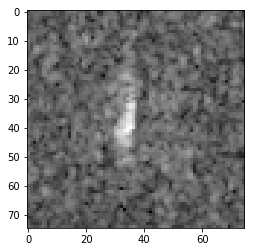

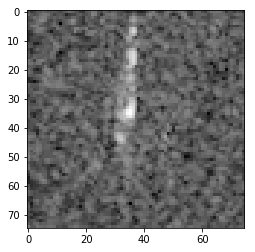

In [31]:
hh_channel, hv_channel = get_image_channels(X_test__, 6)
display_image(hh_channel)
display_image(hv_channel)


In [ ]:


lrc = AdaBoostClassifier(random_state = 3)
#lrc = SVC(random_state = 3)

results = {}
    
start = time() # Get start time
lrc.fit(res_f, y_train__)
end = time() # Get end time
results['train_time'] = end - start


start = time() # Get start time
predictions_test = lrc.predict(res_f_v)
predictions_train = lrc.predict(res_f)
end = time() # Get end time
    
results['pred_time'] = end - start
results['acc_train'] = accuracy_score(y_train__, predictions_train)
results['log_loss_train'] = log_loss(y_train__, predictions_train)
results['acc_test'] = accuracy_score(y_test__, predictions_test)
results['log_loss_test'] = log_loss(y_test__, predictions_test)
       
print ("{} trained on {} samples.".format(lrc.__class__.__name__, len(res_f)))

results


In [32]:
print(X_test.shape)

(8424, 75, 75, 3)


In [34]:
rest = []

for model in prediction_models:
    rest.append(model.predict(X_test))
    
res_t = np.array(rest)

print(res_t.shape)
res = np.mean(res_t, axis=0)

(7, 8424, 1)


In [35]:
print(res.shape)

(8424, 1)


In [36]:
print(y_test.shape)

(8424,)


In [37]:
print(y_test)

[0 0 0 ..., 0 0 0]


In [38]:
import csv
headers = ['id', 'is_iceberg']

with open('results.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(headers)

    for prediction, item_id in zip(res, ids):
        csv_writer.writerow([item_id, np.asscalar(prediction)])

    